In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


In [2]:
# read the data

data_path = '/kaggle/input/titanic-dataset/Titanic-Dataset.csv'

df = pd.read_csv(data_path)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# check for missing values

df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# split the data into train and test

from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.2,random_state=56)

print(train.shape,test.shape)

(712, 12) (179, 12)


In [5]:
# distribution of P class in the overall data

df['Pclass'].value_counts()


Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [6]:
# distribution of P class in the training data

train['Pclass'].value_counts()

Pclass
3    396
1    170
2    146
Name: count, dtype: int64

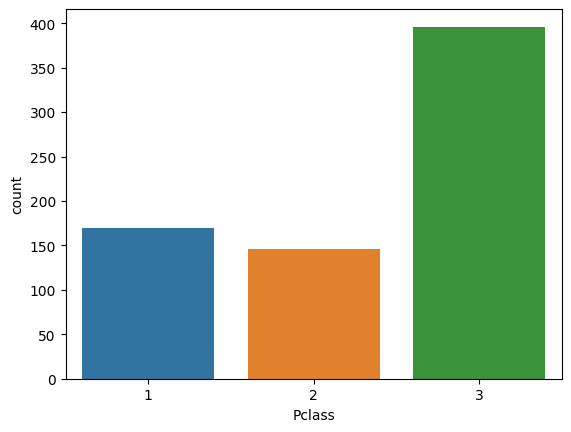

In [7]:
# plot the distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(train,x='Pclass')
plt.show()

## Chi2 Goodness of Fit Test

In [8]:
# infer whether the P class variable follows a uniform distribution

observed_vals = train['Pclass'].value_counts().values
expected_vals = train['Pclass'].value_counts().sum() / 3

expected_vals = np.array([expected_vals] * 3)
expected_vals

array([237.33333333, 237.33333333, 237.33333333])

In [9]:
# calculate the chi2 statistic

test_stat_manual = np.sum(np.square(observed_vals-expected_vals) / expected_vals) 
test_stat_manual

160.32584269662922

In [10]:
from scipy.stats import chi2

In [11]:
# calculate the degree of freedom

dof = 2

p_val = chi2.sf(x=test_stat_manual,df=dof)
p_val

1.5335064436345743e-35

In [12]:
alpha = 0.05

if p_val < alpha:
    print('Reject the H_0, The variable does not follow a uniform distribution')
else:
    print('Fail to reject H_0, The variable follows a uniform distribution')

Reject the H_0, The variable does not follow a uniform distribution


In [13]:
# repeat the same step with scipy lib

from scipy.stats import chisquare

test_stat_lib, p_val_lib = chisquare(f_obs=observed_vals)

test_stat_lib, p_val_lib

(160.32584269662922, 1.5335064436345743e-35)

In [14]:
# compare the results

test_stat_manual, test_stat_lib

(160.32584269662922, 160.32584269662922)

In [15]:
p_val, p_val_lib

(1.5335064436345743e-35, 1.5335064436345743e-35)

## Chi2 Test for Independence

In [16]:
# distribution of Pclass and Survived
# build the contingency table

contingency_table = pd.crosstab(index=train['Pclass'],columns=train['Survived'])
contingency_table

Survived,0,1
Pclass,,
1,57,113
2,77,69
3,299,97


In [17]:
def calculate_expected_frequencies(row_var,col_var):
    rows = row_var.unique()
    columns = col_var.unique()
    contingency_table = pd.crosstab(index=row_var,columns=col_var,margins=True)
    total = contingency_table.loc['All','All']
    expected_contingency = pd.DataFrame(index=rows,columns=columns)
    
    for row in rows:
        for col in columns:
            row_prob = contingency_table.loc[row,'All'] / total
            col_prob = contingency_table.loc['All',col] / total
            expected_contingency.loc[row,col] = row_prob * col_prob * total
        
    expected_contingency.sort_index(axis=0,ascending=True,inplace=True)
    expected_contingency.sort_index(axis=1,ascending=True,inplace=True)
    return expected_contingency


    
expected_contingency = calculate_expected_frequencies(row_var=train['Pclass'],col_var=train['Survived'])
expected_contingency = expected_contingency.astype(np.float64)    

In [18]:
expected_contingency.values

array([[103.38483146,  66.61516854],
       [ 88.78932584,  57.21067416],
       [240.8258427 , 155.1741573 ]])

In [19]:
contingency_table.values

array([[ 57, 113],
       [ 77,  69],
       [299,  97]])

In [20]:
# calculate the test statistic

test_stat_manual = np.sum(np.square(expected_contingency.values - contingency_table.values) / expected_contingency.values)
test_stat_manual

92.9659920399711

In [21]:
# calculate the degree of freedom

dof = 2

p_val = chi2.sf(x=test_stat_manual,df=dof)
p_val

6.496677763229997e-21

In [22]:
alpha = 0.05

if p_val < alpha:
    print('Reject the H_0, Both Variables are dependent on each other')
else:
    print('Fail to reject H_0, Both Variables are independent from each other')

Reject the H_0, Both Variables are dependent on each other


In [23]:
from scipy.stats import chi2_contingency

test_stat_lib, p_val_lib, dof_lib, expected_vals_lib = chi2_contingency(observed=contingency_table)

In [24]:
# compare the results

test_stat_manual,test_stat_lib

(92.9659920399711, 92.96599203997107)

In [25]:
p_val, p_val_lib

(6.496677763229997e-21, 6.496677763230092e-21)

In [26]:
dof, dof_lib

(2, 2)

In [27]:
expected_contingency.values, expected_vals_lib

(array([[103.38483146,  66.61516854],
        [ 88.78932584,  57.21067416],
        [240.8258427 , 155.1741573 ]]),
 array([[103.38483146,  66.61516854],
        [ 88.78932584,  57.21067416],
        [240.8258427 , 155.1741573 ]]))